## Fourier Modes, Bar Formation, Gas Flows

The purpose of this notebook is to investigate why some simulations seem to form bars and others don't. The primary method of seeing how "barry" a simulation is will be through the investigation of Fourier modes, which are simple to calculate and seem to be relatively stable. The question is - is the formation or non-formation of the bar related to how much radial gas flow happens to occur at the early stages of the bar forming?

In [12]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm
import astropy.units as u
from numba import njit
import time

In [2]:
sim = ['fRpoly-Rcore1.0', 'fRpoly2-Rcore1.0']

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

### Center of Mass

First I want to look and see just how much the center of mass of the system shifts throughout the course of the sim. To do this, I will compute the center of mass using a standard iterative technique for sim 0.

In [60]:
def find_com(snap, Rinit=20, Rmin=0.2, Rfac=0.8, components=[0, 1, 2, 3, 4], com_init=np.array([200, 200, 200])):
    pos = np.array([]).reshape(0, 3)
    mass = np.array([])
    
    for i in components:
        if snap.NumPart_Total[i] > 0:
            part = getattr(snap, 'part'+str(i))
            pos = np.concatenate((pos, part.pos))
            if snap.MassTable[i] > 0:
                mass = np.concatenate((mass, np.full(snap.NumPart_Total[i], snap.MassTable[i])))
            else:
                mass = np.concatenate((mass, part.mass))
    
    Rtest = Rinit
    com = com_init
    while Rtest > Rmin:
        pos_minus_com = np.subtract(pos, com)
        key = np.where(np.linalg.norm(pos_minus_com, axis=1) < Rtest)[0]
        com = np.average(pos[key], weights=mass[key], axis=0)
        Rtest *= Rfac
    
    return com
    

In [59]:
%%time
snap = read_snap(0, 0, parttype=[0, 1, 2, 3, 4, 5], fields=['Coordinates', 'Masses'])

CPU times: user 350 ms, sys: 302 ms, total: 652 ms
Wall time: 664 ms


In [65]:
%%time
com = find_com(snap)

CPU times: user 19.6 s, sys: 10.1 s, total: 29.7 s
Wall time: 29.8 s


In [62]:
tlist = []
com_list = []
for i in tqdm(np.arange(0, 200, 10)):
    snap = read_snap(i, 0, parttype=[0, 1, 2, 3, 4, 5], fields=['Coordinates', 'Masses'])
    com = find_com(snap)
    
    tlist.append(snap.Time)
    com_list.append(com)

tlist = np.array(tlist)
com_list = np.array(com_list)



  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:30<09:31, 30.08s/it]

 10%|█         | 2/20 [01:05<09:28, 31.58s/it]

 15%|█▌        | 3/20 [01:34<08:47, 31.02s/it]

 20%|██        | 4/20 [02:10<08:36, 32.31s/it]

 25%|██▌       | 5/20 [02:45<08:16, 33.13s/it]

 30%|███       | 6/20 [03:20<07:51, 33.65s/it]

 35%|███▌      | 7/20 [03:54<07:22, 34.00s/it]

 40%|████      | 8/20 [04:29<06:50, 34.18s/it]

 45%|████▌     | 9/20 [05:04<06:18, 34.39s/it]

 50%|█████     | 10/20 [05:39<05:45, 34.55s/it]

 55%|█████▌    | 11/20 [06:17<05:20, 35.66s/it]

 60%|██████    | 12/20 [06:58<04:58, 37.37s/it]

 65%|██████▌   | 13/20 [07:49<04:50, 41.44s/it]

 70%|███████   | 14/20 [08:46<04:35, 45.99s/it]

 75%|███████▌  | 15/20 [09:35<03:55, 47.00s/it]

 80%|████████  | 16/20 [10:31<03:17, 49.49s/it]

 85%|████████▌ | 17/20 [11:28<02:35, 51.75s/it]

 90%|█████████ | 18/20 [12:25<01:47, 53.52s/it]

 95%|█████████▌| 19/20 [13:27<00:55, 55.89s/it]

100%|██████████| 20/20 [14:31<00:00,

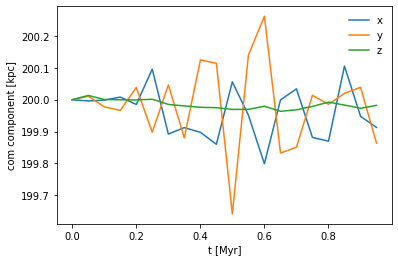

In [63]:
plt.plot(tlist, com_list[:,0], label='x')
plt.plot(tlist, com_list[:,1], label='y')
plt.plot(tlist, com_list[:,2], label='z')

plt.xlabel('t [Myr]')
plt.ylabel('com component [kpc]')
plt.legend(frameon=False)
plt.show()

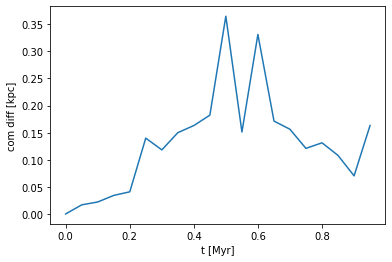

In [64]:
com_diff = com_list - np.array([200, 200, 200])
com_diff_mag = np.linalg.norm(com_diff, axis=1)

plt.plot(tlist, com_diff_mag)

plt.xlabel('t [Myr]')
plt.ylabel('com diff [kpc]')
plt.show()

### Fourier Components
Center of mass seems to be relatively stable. Detailed analysis (to be done later) should take this into account, but for now we can accept a shift of ~300 pc.

Now, we need to compute the fourier component of just the disk component.

In [55]:
def fourier_component(pos, mass, m, Rmin, Rmax, nbins=20, logspace=True, amplitude=False):

#     assert isinstance(m, int), "m must be an integer!"
#     assert isinstance(float(Rmin), float), "Rmin must be a float!"
#     assert isinstance(float(Rmax), float), "Rmax must be a float!"
    t0 = time.time()

    if logspace:
        bins = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins)
    else:
        bins = np.linspace(Rmin, Rmax, nbins)

    # loop through types and concatenate positions and masses    
    Rmag = np.linalg.norm(pos[:,:2], axis=1)

    keys = np.logical_and(Rmag > Rmin, Rmag < Rmax)

    # get output R list by averaging the value of R in each bin
    digit = np.digitize(Rmag[keys], bins)
#     R_list = np.zeros(len(bins)-1)
#     for i in range(len(R_list)):
#         R_list = np.mean(Rmag[keys][digit == i])
    R_list = [Rmag[keys][digit == i].mean() for i in range(1, len(bins))]

    # compute the Am term for each particle
    phi_list = np.arctan2(pos[:,1], pos[:,0])
    Am_i = mass*np.exp((1j)*m*phi_list)

    if amplitude:
        Am_list = [np.abs(np.sum(Am_i[keys][digit == i])) for i in range(1, len(bins))]
        t1 = time.time()
        print(m, t1-t0)
        return np.array(R_list), np.array(Am_list)
    else:
        Am_list_real = [np.sum(np.real(Am_i[keys][digit == i])) for i in range(1, len(bins))]
        Am_list_imag = [np.sum(np.imag(Am_i[keys][digit == i])) for i in range(1, len(bins))]
        t1 = time.time()
        print(m, t1-t0)
        return np.array(R_list), np.array(Am_list_real), np.array(Am_list_imag)

In [62]:
@njit
def fourier_component_njit(pos, mass, m, Rmin, Rmax, nbins=20, logspace=True):
    if logspace:
        bins = np.linspace(np.log10(Rmin), np.log10(Rmax), nbins+1)
        bins = np.power(10., bins)
    else:
        bins = np.linspace(Rmin, Rmax, nbins+1)
    
    Am_real = np.zeros(nbins)
    Am_imag = np.zeros(nbins)
    Rmag = np.zeros(nbins)
    N_in_bin = np.zeros(nbins)
    
    Npart = len(pos)
    for i in range(Npart):
        R = np.sqrt(pos[i][0]*pos[i][0] + pos[i][1]*pos[i][1])
        phi = np.arctan2(pos[i][1], pos[i][0])
        
        for j in range(nbins):
            if R > bins[j] and R < bins[j+1]:
                Am_real[j] += mass[j]*np.cos(m*phi)
                Am_imag[j] += mass[j]*np.sin(m*phi)
                Rmag[j] += R
                N_in_bin[j] += 1
    
    
    for j in range(nbins):
        Rmag[j] /= N_in_bin[j]
    
    return Rmag, Am_real, Am_imag
    

In [31]:
bins = fourier_component(0, 0, 0, 1, 10, logspace=True)
bins

array([ 1.        ,  1.12201845,  1.25892541,  1.41253754,  1.58489319,
        1.77827941,  1.99526231,  2.23872114,  2.51188643,  2.81838293,
        3.16227766,  3.54813389,  3.98107171,  4.46683592,  5.01187234,
        5.62341325,  6.30957344,  7.07945784,  7.94328235,  8.91250938,
       10.        ])

In [64]:
def compute_fourier_components(snap, Rmin=0.0, Rmax=30.0, nbins=60, logspace=False, center=np.array([200, 200, 200])):
    # try loading snapshot
    t0 = time.time()
    firstpart = True
    for i, npart in enumerate(snap.NumPart_Total):
        if i not in [2, 3, 4]:
            continue

        if npart == 0:
            continue

        part = getattr(snap, 'part'+str(i))

        # compute the center of mass
        this_mass = snap.MassTable[i].as_unit(arepo.u.msol).value
        this_pos = part.pos.as_unit(arepo.u.kpc).value

        if center is not None:
            this_pos = np.subtract(this_pos, center)

        # if mass is zero, then we need to load each individual mass
        if this_mass == 0:
            this_mass = part.mass.as_unit(arepo.u.msol).value
        else:
            this_mass = np.full(npart, this_mass)

        # now concatenate if needed
        if firstpart:
            mass = np.copy(this_mass)
            pos = np.copy(this_pos)
            firstpart = False
        else:
            mass = np.concatenate((mass, this_mass))
            pos = np.concatenate((pos, this_pos))
    
    Rlist, A0, _ = fourier_component_njit(pos, mass, 0, Rmin, Rmax, nbins=nbins, logspace=logspace)
    
    Rlist, A1r, A1i = fourier_component_njit(pos, mass, 1, Rmin, Rmax, nbins=nbins, logspace=logspace)
    
    Rlist, A2r, A2i = fourier_component_njit(pos, mass, 2, Rmin, Rmax, nbins=nbins, logspace=logspace)
    
    Rlist, A4r, A4i = fourier_component_njit(pos, mass, 4, Rmin, Rmax, nbins=nbins, logspace=logspace)

#     Rlist, A3r, A3i = fourier_component(pos, mass, 3, Rmin, Rmax, 
#                                        nbins=nbins, logspace=logspace, amplitude=False)
#     Rlist, A4r, A4i = fourier_component(pos, mass, 4, Rmin, Rmax, 
#                                        nbins=nbins, logspace=logspace, amplitude=False)
#     Rlist, A5r, A5i = fourier_component(pos, mass, 5, Rmin, Rmax, 
#                                        nbins=nbins, logspace=logspace, amplitude=False)
#     Rlist, A6r, A6i = fourier_component(pos, mass, 6, Rmin, Rmax, 
#                                        nbins=nbins, logspace=logspace, amplitude=False)
#     Rlist, A7r, A7i = fourier_component(pos, mass, 7, Rmin, Rmax, 
#                                        nbins=nbins, logspace=logspace, amplitude=False)
#     Rlist, A8r, A8i = fourier_component(pos, mass, 8, Rmin, Rmax, 
#                                        nbins=nbins, logspace=logspace, amplitude=False)
#     Rlist, A9r, A9i = fourier_component(pos, mass, 9, Rmin, Rmax, 
#                                        nbins=nbins, logspace=logspace, amplitude=False)
#     Rlist, A10r, A10i = fourier_component(pos, mass, 10, Rmin, Rmax, 
#                                        nbins=nbins, logspace=logspace, amplitude=False)
    
    t = snap.Time.as_unit(arepo.u.d).value * u.d
    t = t.to_value(u.Myr)

    out = {}
    out['Rlist'] = Rlist
    out['A0'] = A0
    out['A1r'], out['A1i'] = A1r, A1i
    out['A2r'], out['A2i'] = A2r, A2i
#     out['A3r'], out['A3i'] = A3r, A3i
    out['A4r'], out['A4i'] = A4r, A4i
#     out['A5r'], out['A5i'] = A5r, A5i
#     out['A6r'], out['A6i'] = A6r, A6i
#     out['A7r'], out['A7i'] = A7r, A7i
#     out['A8r'], out['A8i'] = A8r, A8i
#     out['A9r'], out['A9i'] = A9r, A9i
#     out['A10r'], out['A10i'] = A10r, A10i
    out['time'] = t
    
    
    return out

In [5]:
%%time
snap = read_snap(0, 0, parttype=[2, 3, 4, 5], fields=['Coordinates', 'Masses'])

CPU times: user 266 ms, sys: 1.13 s, total: 1.4 s
Wall time: 5.2 s


In [65]:
%%time
out = compute_fourier_components(snap)

CPU times: user 3.71 s, sys: 111 ms, total: 3.82 s
Wall time: 3.83 s


In [75]:
snap_list = []
for i in tqdm(np.arange(0, 400)):
    snap = read_snap(i, 0, parttype=[2, 3, 4], fields=['Coordinates', 'Masses'])
    snap_list.append(snap)

 18%|█▊        | 74/400 [07:00<36:39,  6.75s/it]

KeyboardInterrupt: 

In [73]:
out_list = []
for i in tqdm(np.arange(0, 200, 10)):
    snap = read_snap(i, 0, parttype=[2, 3, 4], fields=['Coordinates', 'Masses'])
    out_list.append(compute_fourier_components(snap))

100%|██████████| 20/20 [03:05<00:00,  9.67s/it]


[0.0, 49.1761121924671, 97.8747864024831, 147.05089859495018, 195.7495728049662, 244.44824701498214, 293.62435920744923, 342.3230334174652, 391.4991456099324, 440.1978198199483, 488.8964940299643, 538.0726062224314, 586.7712804324474, 635.9473926249145, 684.6460668349304, 733.3447410449464, 782.5208532374135, 831.2195274474295, 880.3956396398966, 929.0943138499126]


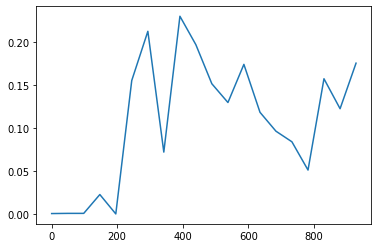

In [74]:
tlist = []
A2list = []

idx=4

for out in out_list:
    tlist.append(out['time'])
    A2 = np.sqrt(out['A2r'][idx]*out['A2r'][idx] + out['A2i'][idx]*out['A2i'][idx])
    A0 = out['A0'][idx]
    A2list.append(A2/A0)
print(tlist)
    
plt.plot(tlist, A2list)
plt.show()